# Gesture Recognition Case Study
- **Team : Sudeep K S & Souvik Sen**<br>
- **Batch: ML C38**<br>
- **Date : 1 OCT 2022**<br>
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.<br>

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:<br>

- Thumbs up: Increase the volume<br>
- Thumbs down: Decrease the volume<br>
- Left swipe: 'Jump' backwards 10 seconds<br>
- Right swipe: 'Jump' forward 10 seconds<br>
- Stop: Pause the movie<br>
- Each video is a sequence of 30 frames (or images).

## Objectives
Need to accomplish the following in the project:<br>
    1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.<br><br>
    2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.<br><br>
    3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## importing Few More libraries needed for the model building.
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
## Checking the GPU configuration

!nvidia-smi

Sun Oct  9 09:50:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   26C    P8    13W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10

In [5]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].title.set_text("Train loss vs Validation loss")

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Generator is updated to take follwoing parameters:<br>
- **batch_size** - Size of the mini batches<br>
- **frames_per_video** - Number of frames to be considered per video<br>
- **height** - Resize dimension - height<br>
- **width** - Resize dimension - width<br>
- **apply_augmentation** - Boolean to indicate whether to apply augmentation or not.

In [6]:
# Parameters initialization
image_width = 120   # X dimension of the image
image_height = 120   # Y dimesnion of the image
total_frames = 30  # lenght of the video frames
channels = 3 # number of channels in images 3 for color(RGB) and 1 for Gray

In [7]:
# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    AF = np.float32([[1, 0, dx], [0, 1, dy]])
    return AF

# Helper function to initialize all the batch image data and labels
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, total_frames, image_width, image_height, channels)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

### Genarator Function

In [8]:
def generator(source_path, folder_list, batch_size, augument_false=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,augument_false)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,augument_false)

In [9]:
def load_batch_images(source_path, folder_list, batch_num, batch_size, t,augument_false):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, total_frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        AF = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes 
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
             
            resized = cv2.resize(image, (image_height,image_width), interpolation = cv2.INTER_AREA) 
          
            #Normalize data

            batch_data[folder,idx,:,:,0] = cv2.normalize(resized[:,:,0],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,1] = cv2.normalize(resized[:,:,1],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,2] = cv2.normalize(resized[:,:,2],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            
            #Data with affine transformation
            affined = (cv2.warpAffine(resized, AF, (resized.shape[0], resized.shape[1])))

            batch_data[folder,idx,:,:,0] = cv2.normalize(affined[:,:,0],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,1] = cv2.normalize(affined[:,:,1],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,2] = cv2.normalize(affined[:,:,2],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            
            

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
                      
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 

    
    if augument_false:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
                
    return batch_data_final,batch_labels_final

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


### Genarator Validation

In [11]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, augument_false=True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, augument_false=True)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /home/datasets/Project_data/train ; batch size = 10
(10, 30, 120, 120, 3)
Source path =  /home/datasets/Project_data/val ; batch size = 10
(10, 30, 120, 120, 3)


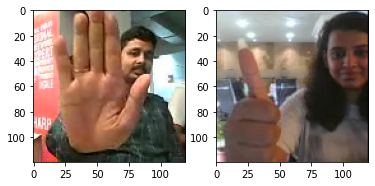

In [12]:
# plot generated sample images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample_batch_data[2,29,:,:,:])   
axes[1].imshow(sample_batch_data[6,29,:,:,:])
plt.show()

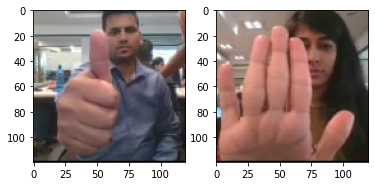

In [13]:
# plot generated sample images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample_val_batch_data[2,29,:,:,:])   
axes[1].imshow(sample_val_batch_data[6,29,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# 1. Base Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[1], activation='relu'))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
base_model=define_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 16)   6

2022-10-09 09:50:13.274366: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-09 09:50:13.274432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
# execution of the sample model
#batch_size = 512
#num_epochs = 10
#train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
#val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

#print("Total Params:", base_model.count_params())
#history_model_base =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

With batch_size=512 Error Seen<br>
- ResourceExhaustedError:  OOM when allocating tensor with shape[512,8,30,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

### Inference
 Executing with lower batch sizes and epochs

In [20]:
# execution of the sample model
batch_size = 10
num_epochs = 10

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model1 =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/10


2022-10-09 09:50:16.176024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 4.5934 - categorical_accuracy: 0.4118Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-4.59344-0.41176-1.67278-0.38000.h5
67/67 [==============================] - 84s 1s/step - loss: 4.5934 - categorical_accuracy: 0.4118 - val_loss: 1.6728 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.0748 - categorical_accuracy: 0.6070
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.07479-0.60697-2.73728-0.18000.h5
67/67 [==============================] - 33s 499ms/step - loss: 1.0748 - categorical_accuracy: 0.6070 - val_loss: 2.7373 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 1.0374 - categorical_accuracy: 0.6269
Epoch 00003: saving model to model_init_2022-10-0909_50_10.447697/m

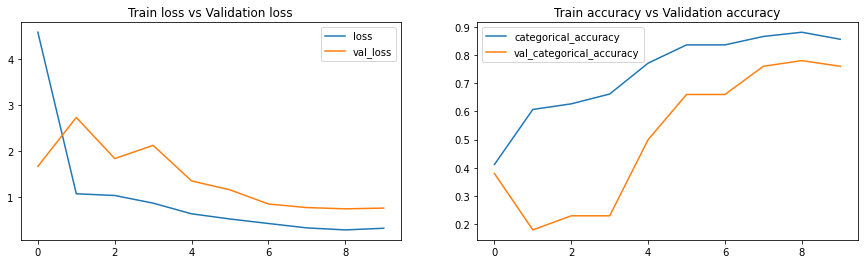

In [21]:
# plot the score
plot(history_model1)

#### Analysis
There is a difference in training and validation, Looks like there is overfitting

# 2 Base Model

In [22]:
batch_size = 10
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model2 =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.1290 - categorical_accuracy: 0.5317Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-1.12897-0.53167-1.24552-0.69000.h5
67/67 [==============================] - 86s 1s/step - loss: 1.1290 - categorical_accuracy: 0.5317 - val_loss: 1.2455 - val_categorical_accuracy: 0.6900 - lr: 5.0000e-04
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.0031 - categorical_accuracy: 0.5224
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.00307-0.52239-0.91395-0.71000.h5
67/67 [==============================] - 34s 503ms/step - loss: 1.0031 - categorical_accuracy: 0.5224 - val_loss: 0.9140 - val_categorical_accuracy: 0.7100 - lr: 5.0000e-04
Epoch 3/15
67/67 [==============================] - ETA: 0s - los

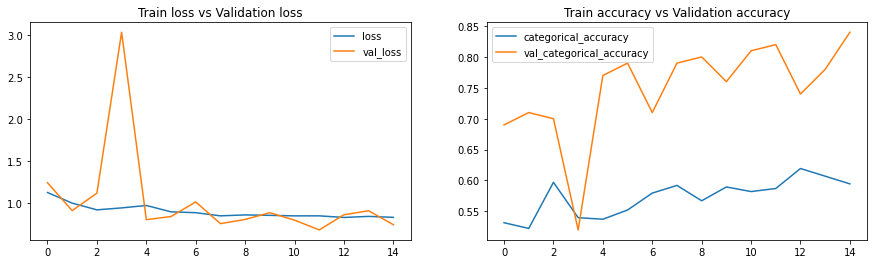

In [23]:
# plot the score
plot(history_model2)

#### Analysis
Data augmentation does not help here, We will not use the augmented data in any of the model in this case study.
We will now tune the model by reducing filter sizes

# 3 Base Model
Lets Reduce the filter Size to (2,2,2), to see if that improve the performace.

In [24]:
def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))


    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[0], activation='relu'))
    
    
    model.add(Dense(dense_neurons[1], activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [25]:
conv_3d1_model0=define_model()
conv_3d1_model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 16)    1040      
                                                                 
 batch_normalization_4 (Batc  (None, 15, 60, 60, 16)  

In [26]:
batch_size = 10
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model3 =conv_3d1_model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 4.8412 - categorical_accuracy: 0.3560Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-4.84122-0.35596-2.11837-0.21000.h5
67/67 [==============================] - 84s 1s/step - loss: 4.8412 - categorical_accuracy: 0.3560 - val_loss: 2.1184 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.3401 - categorical_accuracy: 0.4527
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.34005-0.45274-2.09701-0.19000.h5
67/67 [==============================] - 36s 533ms/step - loss: 1.3401 - categorical_accuracy: 0.4527 - val_loss: 2.0970 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.413

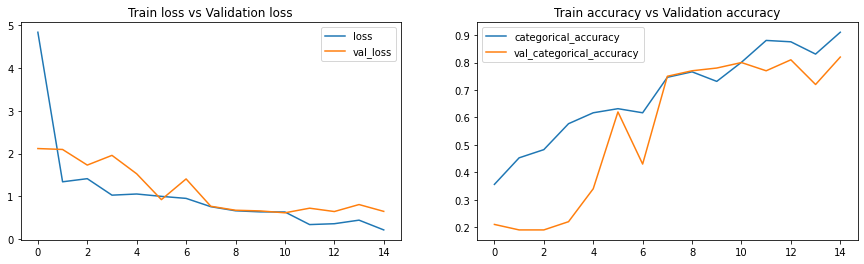

In [27]:
plot(history_model3)

#### Analysis
- Reducing kernel size from (3,3,3) to (2,2,2) increase the depth of the network a bit and thus improve the performance a bit.
- Let tune the model by updating the model by adding more layers, dropout, reducing parameters and tuning hyperparameters.

# 4. CNN CONV3D

Let tune the model by updating the model by adding more layers, dropout, reducing parameters and tuning hyperparameters. Batch Size = 10, and No. of Epochs = 40

In [28]:
def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[0], activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(dense_neurons[1], activation='relu'))
    model.add(Dropout(0.5))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [29]:
conv_3d1_model=define_model()
conv_3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_7 (Batc  (None, 15, 60, 60, 16)  

In [30]:
batch_size = 10
num_epochs = 40

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", conv_3d1_model.count_params())
history_model4 =conv_3d1_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 864101
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/40
67/67 [==============================] - ETA: 0s - loss: 1.8342 - categorical_accuracy: 0.3152Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-1.83421-0.31523-1.59797-0.26000.h5
67/67 [==============================] - 81s 1s/step - loss: 1.8342 - categorical_accuracy: 0.3152 - val_loss: 1.5980 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 1.4501 - categorical_accuracy: 0.3632
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.45008-0.36318-1.60497-0.22000.h5
67/67 [==============================] - 34s 520ms/step - loss: 1.4501 - categorical_accuracy: 0.3632 - val_loss: 1.6050 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/40
67/67 [==============================] - ETA: 0s - loss: 1.5324

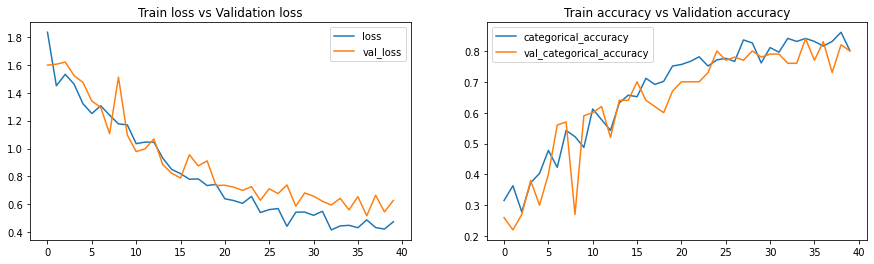

In [31]:
plot(history_model4)

#### Analysis
From the accuracy score, loss value and the plot, we can say this model is doing decent.
* Training Accuracy : 80.10 %
* Validation Accuracy : 80.00 %

# 5. CONV3D & LSTM

In [32]:
def define_model(lstm_cells=128,dense_neurons=128,dropout=0.5):
      
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
# RNN CNN MODEL SUMMARY
rnn_cnn1_model=define_model()
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [34]:
batch_size = 10
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn1_model.count_params())
history_model5=rnn_cnn1_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 1657445
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6567 - categorical_accuracy: 0.2775Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-1.65671-0.27753-1.75335-0.21000.h5
67/67 [==============================] - 81s 1s/step - loss: 1.6567 - categorical_accuracy: 0.2775 - val_loss: 1.7534 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.5401 - categorical_accuracy: 0.3731
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.54014-0.37313-2.36139-0.20000.h5
67/67 [==============================] - 31s 465ms/step - loss: 1.5401 - categorical_accuracy: 0.3731 - val_loss: 2.3614 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.681

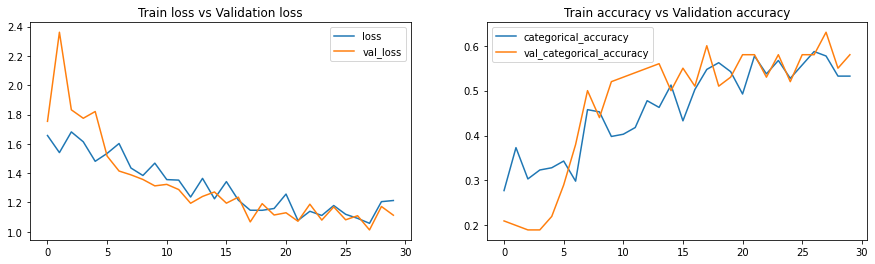

In [35]:
plot(history_model5)

#### Analysis
Similar outcome as previous model, no significant improvement

# 6. CONV2D with GRU

In [36]:
def define_model(lstm_cells,dense_neurons,dropout):
        
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(5, activation='softmax'))
        
        optimiser = keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
rnn_cnn2_model=define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)  

In [38]:
batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn2_model.count_params())
history_model6=rnn_cnn2_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2573925
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.4415 - categorical_accuracy: 0.3937Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-1.44155-0.39367-1.94777-0.16000.h5
67/67 [==============================] - 79s 1s/step - loss: 1.4415 - categorical_accuracy: 0.3937 - val_loss: 1.9478 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1322 - categorical_accuracy: 0.5373
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-1.13217-0.53731-2.08417-0.23000.h5
67/67 [==============================] - 32s 487ms/step - loss: 1.1322 - categorical_accuracy: 0.5373 - val_loss: 2.0842 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/25
67/67 [==============================] - ETA: 0s - los

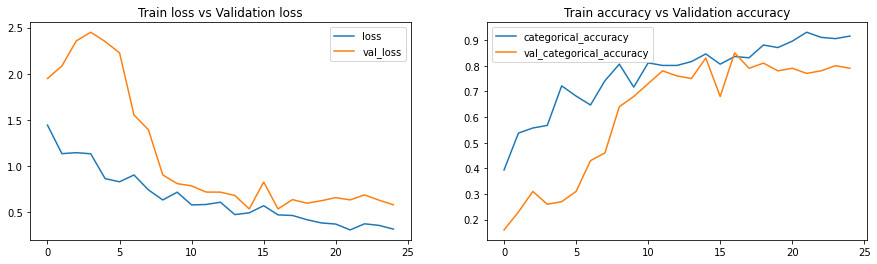

In [39]:
plot(history_model6)

#### Analysis<br>
The training accuracy is 91.5 %, whereas the validation accuracy is 79%, the score is very good, but there is a difference of around 13%. Hence it might be a reason of overfitting

# 7 Transfer Learning with LSTM

In [40]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

def define_model(lstm_cells=64,dense_neurons=64,dropout=0.25):
        #inputshape=(len(img_arr[0]), img_arr[1], img_arr[2], img_arr[3])
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=inputshape))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
rnn_cnn_tl_model=define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [42]:
batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn_tl_model.count_params())
history_model7=rnn_cnn_tl_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 3840453
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.2982 - categorical_accuracy: 0.4555Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-1.29823-0.45551-0.91756-0.64000.h5
67/67 [==============================] - 82s 1s/step - loss: 1.2982 - categorical_accuracy: 0.4555 - val_loss: 0.9176 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.9358 - categorical_accuracy: 0.6617
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-0.93583-0.66169-0.81609-0.73000.h5
67/67 [==============================] - 33s 502ms/step - loss: 0.9358 - categorical_accuracy: 0.6617 - val_loss: 0.8161 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.929

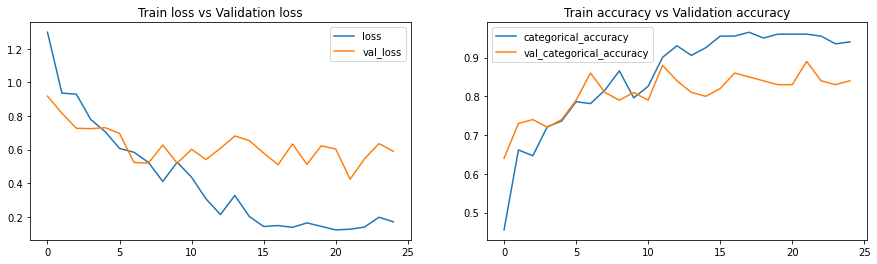

In [43]:
plot(history_model7)

#### Analysis<br>
After transfer learning, we can see that the train accuracy has come up by 3 %, where as the validation accuracy increased by 5 %. There is a little improvement from the last CNN + RRN GRU model score.


# 8. Transfer Learning Mobilenet with GRU and training all weights

In [44]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

    
def define_model(gru_cells=64,dense_neurons=64,dropout=0.25):
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(inputshape)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))

        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
rnn_cnn_tl2_model=define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [46]:
batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model8=rnn_cnn_tl2_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 3693253
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 0.7866 - categorical_accuracy: 0.7089Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2022-10-0909_50_10.447697/model-00001-0.78663-0.70890-0.44047-0.84000.h5
67/67 [==============================] - 87s 1s/step - loss: 0.7866 - categorical_accuracy: 0.7089 - val_loss: 0.4405 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.6400 - categorical_accuracy: 0.8010
Epoch 00002: saving model to model_init_2022-10-0909_50_10.447697/model-00002-0.64000-0.80100-1.03511-0.66000.h5
67/67 [==============================] - 33s 501ms/step - loss: 0.6400 - categorical_accuracy: 0.8010 - val_loss: 1.0351 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.024

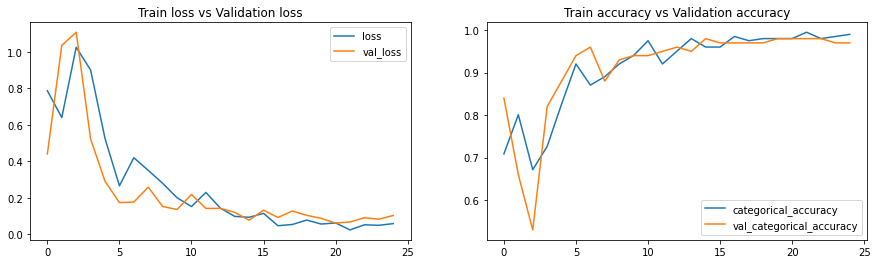

In [47]:
plot(history_model8)

#### Analysis<br>
Excellent score! 99.0% Training accuracy and 97% validation accuracy

# Conclusion

#### After above experimentation, I finalized  Model 4 - CNN CONV3D which performed well.
#### Reason:
* Training Accuracy : 80.10%, Validation Accuracy : 80.00%
* Number of Parameters(864,101) which is far less than other models in the experiment.